In [17]:
from datasets import load_dataset, DatasetDict, Features, Value, Sequence,Image

ds = load_dataset("json", data_files='/Projects/SG_VLN_HumanData/SG-VLN/data/datasets/objectnav/objectnav_mp3d_thda_70k/train_all_pose_depth.jsonl', split="train")
image_root = '/Projects/SG_VLN_HumanData/SG-VLN/data/datasets/objectnav/objectnav_mp3d_thda_70k/objectnav_images_depth'
import os
def make_absolute(example):
    example["rgb_sequence"] = [os.path.join(image_root, p) for p in example["rgb_paths"]]
    example["depth_sequence"] = [os.path.join(image_root,p) for p in example['depth_paths']]
    return example

ds = ds.map(make_absolute, num_proc=16, desc="Fixing Paths")
ds = ds.cast_column('rgb_sequence',Sequence(Image()))

In [18]:
import numpy as np
from PIL import Image as PILImage
from pathlib import Path
from einops import reduce
import numpy as np


def load_depth(
    path: Path,
) -> np.ndarray:
    """
    Reverse the save_depth encoding to retrieve depth in meters.
    
    Inverse Logic:
      y = x / (x + k)  -->  x = (y * k) / (1 - y)
      where x is depth_meters and y is normalized depth [0, 1).
    """
    # 1. Load the 16-bit PNG
    # distinct from standard PNGs, we interpret pixels as 16-bit integers
    img = PILImage.open(path)
    depth_u16 = np.asarray(img, dtype=float)

    # 2. Re-normalize to [0, 1]
    depth_meters = depth_u16 / 1000

    # 3. Invert the monotonic curve
    # Note: If a pixel value is exactly 65535 (saturated), the denominator
    # becomes 0. np.divide handles this by returning inf, which is mathematically correct
    # (x -> infinity as norm -> 1). We suppress the 'divide by zero' warning here.

    return depth_meters

def load_depths(example):
    depths = []
    for path in example['depth_sequence']:
        depths.append(load_depth(path))
    return np.array(depths)

def patch_average_einops(points: np.ndarray, patch_size: int) -> np.ndarray:
    """
    Downsamples the point cloud by averaging points within patches.
    
    Args:
        points: Shape (..., H, W, 3)
        patch_size: int (e.g., 14 or 16)
        
    Returns:
        Shape (..., h, w, 3) where h=H/patch_size, w=W/patch_size
    """
    # '... (h p1) (w p2) c' captures the batch dim in '...'
    # p1 and p2 capture the patch height/width
    return einops.reduce(
        points, 
        '... (h p1) (w p2) c -> ... h w c', 
        'mean', 
        p1=patch_size, 
        p2=patch_size
    )

import numpy as np
import einops

def depth_to_pointcloud(depth: np.ndarray, fov_degrees: float = 90.0) -> np.ndarray:
    """
    Vectorized unprojection.
    
    Args:
        depth: Shape (H, W) or (B, H, W)
        fov_degrees: Horizontal Field of View
        
    Returns:
        points: Shape (..., H, W, 3) where ... matches input batch dims.
        Coordinates are CV standard: X Right, Y Down, Z Forward.
    """
    # 1. Determine shapes and intrinsics
    # We assume depth is at least 2D. The last two dims are H, W.
    H, W = depth.shape[-2:]
    
    # Calculate focal length from FOV
    # f = (W / 2) / tan(FOV / 2)
    f = (W / 2) / np.tan(np.deg2rad(fov_degrees / 2))
    
    # Principal point (center)
    cx, cy = W / 2, H / 2
    
    # 2. Create the Grid (Vectorized)
    # create generic [0...W-1] and [0...H-1]
    u = np.arange(W)
    v = np.arange(H)
    uu, vv = np.meshgrid(u, v)  # shapes: (H, W)
    
    # 3. Unproject
    # Note: we subtract cx, cy then multiply by depth.
    # NumPy Broadcasting Magic:
    # uu (H, W) - cx (scalar) -> (H, W)
    # (H, W) * depth (B, H, W) -> (B, H, W) automatically aligns trailing dims.
    
    z = depth
    x = (uu - cx) * z / f
    y = (vv - cy) * z / f
    
    # 4. Stack
    # We stack along the LAST axis to get (..., H, W, 3)
    points = np.stack([x, y, z], axis=-1)
    
    return points

import numpy as np
from scipy.spatial.transform import Rotation as R

def pos_rots_to_matrix(pos_rots: np.ndarray) -> np.ndarray:
    """
    Converts 7D vector [x, y, z, qx, qy, qz, qw] to 4x4 transformation matrix.
    
    Args:
        pos_rots: Numpy array of shape (..., 7)
    Returns:
        Numpy array of shape (..., 4, 4)
    """
    # Split position and rotation
    pos = pos_rots[..., :3]
    quat = pos_rots[..., 3:] # [qx, qy, qz, qw]
    
    # Create the 4x4 matrix container
    # Shape logic: if input is (N, 7), output is (N, 4, 4)
    batch_shape = pos_rots.shape[:-1]
    T = np.eye(4)
    # Broadcast identity if we have batch dims
    if batch_shape:
        T = np.tile(T, (*batch_shape, 1, 1))
        
    # Scipy handles the batch quaternion to rotation matrix conversion automatically
    # Note: Scipy expects scalar-last quaternions [x, y, z, w], which matches your format
    rot_matrices = R.from_quat(quat).as_matrix()
    
    T[..., :3, :3] = rot_matrices
    T[..., :3, 3] = pos
    
    return T
def get_cv_to_habitat_correction() -> np.ndarray:
    """
    Returns the static 4x4 matrix converting CV Frame -> Habitat Frame.
    Rotate 180 degrees around X-axis (flip Y and Z).
    """
    correction = np.eye(4)
    correction[1, 1] = -1
    correction[2, 2] = -1
    return correction

def transform_points(points: np.ndarray, transform: np.ndarray) -> np.ndarray:
    """
    Applies 4x4 transform to points (..., N, 3).
    """
    # 1. Homogeneous coordinates
    # Append 1s to the last dimension
    ones = np.ones((*points.shape[:-1], 1))
    points_hom = np.concatenate([points, ones], axis=-1)
    print(points_hom.shape)
    # 2. Matrix Multiplication
    # (..., N, 4) @ (..., 4, 4).T -> (..., N, 4)
    # We transpose the last two dims of the transform
    points_transformed = points_hom @ np.swapaxes(transform, -1, -2)
    
    # 3. Crop back to 3D
    return points_transformed[..., :3]
def transform_points_batch(points: np.ndarray, transform: np.ndarray) -> np.ndarray:
    """
    Applies a batch of transforms to a batch of point clouds.
    
    Args:
        points: Shape (B, ..., 3)  <-- Can be (B, N, 3) or (B, H, W, 3)
        transform: Shape (B, 4, 4)
        
    Returns:
        points_transformed: Shape (B, ..., 3)
    """
    # 1. Homogeneous Coordinates
    # Append 1 to the last dim. 
    # Result shape: (B, ..., 4)
    ones = np.ones((*points.shape[:-1], 1))
    points_hom = np.concatenate([points, ones], axis=-1)
    
    points_transformed = np.einsum('b...i, bji -> b...j', points_hom, transform)
    
    # 3. Crop back to 3D
    return points_transformed[..., :3]
# --- Usage ---

def convert_cv_points_to_world(points_cv: np.ndarray, pos_rots: np.ndarray) -> np.ndarray:
    """
    Main entry point.
    points_cv: (..., N, 3)
    pos_rots: (..., 7)
    """
    # 1. Agent Pose (Habitat Frame)
    T_world_agent = pos_rots_to_matrix(pos_rots)
    
    # 2. Camera -> Agent Correction
    T_agent_cv = get_cv_to_habitat_correction()
    
    # 3. Combined Transform: Camera -> World
    # If dealing with batches, T_agent_cv broadcasts automatically
    T_world_cv = T_world_agent @ T_agent_cv
    
    # 4. Apply
    return transform_points(points_cv, T_world_cv)

import open3d as o3d
def create_colored_pointcloud(points, rgb_image):
    # ... (Same reshaping/normalization logic as before) ...
    if rgb_image.ndim == 3:
        colors = rgb_image.reshape(-1, 3)
    else:
        colors = rgb_image
        
    if colors.max() > 1.001: 
        colors = colors.astype(np.float64) / 255.0

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Flip orientation for easier viewing (Camera to World)
    # Rotating 180 deg around X-axis
    R = pcd.get_rotation_matrix_from_xyz((np.pi, 0, 0))
    pcd.rotate(R, center=(0, 0, 0))
    
    return pcd

def create_bev_mosaic(
    rgbs: np.ndarray, 
    patch_coords_discrete: np.ndarray, 
    patch_size: int = 32
):
    """
    Creates a Birds-Eye View (BEV) mosaic from image patches.
    
    Args:
        rgbs: Raw RGB images (B, H_img, W_img, 3)
        patch_coords_discrete: Discrete world coords (B, h_grid, w_grid, 3)
        patch_size: Size of the patches (e.g., 32)
        
    Returns:
        canvas: The resulting BEV image (H_map, W_map, 3)
    """
    # 1. Extract High-Res Patches from RGB images
    # We rearrange (B, H, W, C) -> (N, P, P, C)
    # This aligns perfectly with the flattened patch_coords
    patches = einops.rearrange(
        rgbs, 
        'b (h p1) (w p2) c -> (b h w) p1 p2 c', 
        p1=patch_size, 
        p2=patch_size
    )
    
    # 2. Flatten Coordinates and Project to 2D
    # We only care about X (right) and Z (back/forward) for BEV
    # Shape: (N, 3) -> (N, 2) taking columns 0 (x) and 2 (z)
    flat_coords = patch_coords_discrete.reshape(-1, 3)
    xz_coords = flat_coords[:, [0, 2]] 
    
    # 3. Vectorized Averaging of Overlapping Patches
    # Find unique (x, z) coordinates and the inverse mapping
    # unique_xz: (U, 2) - The list of unique grid locations
    # inverse_indices: (N,) - Maps every original patch to a unique location index
    unique_xz, inverse_indices = np.unique(xz_coords, axis=0, return_inverse=True)
    
    # Initialize container for averaged patches: (U, 32, 32, 3)
    unique_patches_sum = np.zeros((len(unique_xz), patch_size, patch_size, 3), dtype=np.float32)
    counts = np.zeros((len(unique_xz),), dtype=np.int32)
    
    # "Scatter Add" logic using numpy
    # This sums all patches that map to the same unique index
    np.add.at(unique_patches_sum, inverse_indices, patches)
    np.add.at(counts, inverse_indices, 1)
    
    # Compute mean (broadcasting the count division)
    unique_patches_avg = unique_patches_sum / counts[:, None, None, None]
    unique_patches_avg = np.clip(unique_patches_avg, 0, 255).astype(np.uint8)

    # 4. Construct the Canvas
    # Determine bounds
    min_x, min_z = unique_xz.min(axis=0)
    max_x, max_z = unique_xz.max(axis=0)
    
    grid_h = (max_z - min_z) + 1
    grid_w = (max_x - min_x) + 1
    
    # Canvas size in pixels
    canvas_h = grid_h * patch_size
    canvas_w = grid_w * patch_size
    
    # Initialize canvas (black background)
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    
    # 5. Paint the Canvas
    # Iterate over the UNIQUE patches (much faster than iterating over all N)
    for i, (gx, gz) in enumerate(unique_xz):
        # Calculate pixel offsets
        # Note: We flip Z logic if necessary. Here we map World Z -> Image Row
        row_idx = (gz - min_z)
        col_idx = (gx - min_x)
        
        y_start = row_idx * patch_size
        x_start = col_idx * patch_size
        
        canvas[y_start : y_start+patch_size, x_start : x_start+patch_size] = unique_patches_avg[i]
        
    return canvas

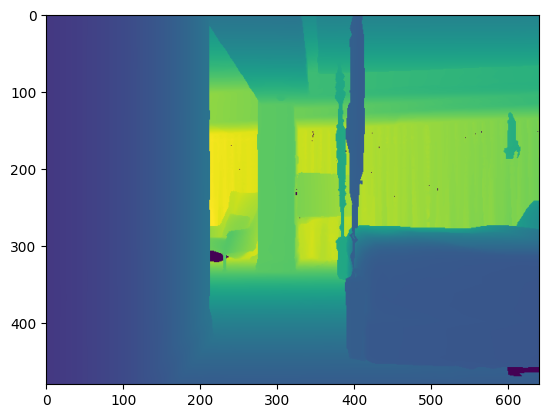

In [20]:

%matplotlib inline
import matplotlib.pyplot as plt
ep_idx = 15
seq_idx =10
depth = load_depth(ds[ep_idx]['depth_sequence'][seq_idx])
plt.imshow(depth)

In [21]:
ep_idx=15
mats = pos_rots_to_matrix(np.array(ds[ep_idx]['pos_rots'])) @ get_cv_to_habitat_correction()
rgbs = np.array(ds[ep_idx]['rgb_sequence'])
depths = load_depths(ds[ep_idx])

In [22]:
# pip install einops
divisor = 1
ps = 32 //divisor
points = depth_to_pointcloud(depths,fov_degrees=90)
patch_coords = patch_average_einops(points,patch_size=ps)
patch_coords_world = transform_points_batch(patch_coords,mats)
patch_coords_discrete = (patch_coords_world/0.15).astype(int)
rgb_patches = patch_average_einops(rgbs.astype(float),patch_size=ps)
print(len(np.unique(patch_coords_world.reshape((-1,3)),axis=0)))
print(len(np.unique(patch_coords_discrete.reshape((-1,3)),axis=0)))

15300
7211


In [23]:
canvas = create_bev_mosaic(rgbs, patch_coords_discrete, patch_size=ps)
from PIL import Image

img = Image.fromarray(canvas)
img.save('bev.png')

In [24]:
mask = (patch_coords_world[...,1]<2)
# mask = np.ones(patch_coords_world.shape[:-1],dtype=bool)
print(mask.shape)
pcd = create_colored_pointcloud(patch_coords_discrete[mask],rgb_patches[mask])
path = Path("test_pcd.ply")
path.parent.mkdir(parents=True, exist_ok=True)

o3d.io.write_point_cloud(str(path), pcd)

(55, 15, 20)


True

In [ ]:




# --- Usage ---
# Assuming 'rgbs' and 'patch_coords_discrete' are available from your previous snippet

# plt.imshow(canvas)
# plt.show()

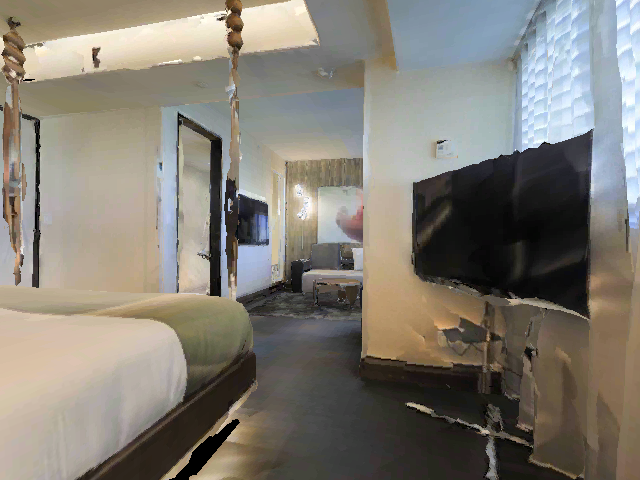

In [15]:
ds[ep_idx]['rgb_sequence'][seq_idx]

In [24]:
import numpy as np
img = np.zeros((2000,2000,3))

for i in range(rgb.shape[0]//ps):
    for j in range(rgb.shape[1]//ps):
        x = patch_coords[i,j,2]*ps
        z = patch_coords[i,j,0]*ps
        y = patch_coords[i,j,1]

        target_vec = np.array([[z//ps,x//ps]])
        row_matches = np.sum(np.all(patch_coords[:,:,[0,2]].reshape(-1,2)==target_vec, axis=1))
        # print(row_matches)
        scale = 1/row_matches
        if y >0:
            img[x:(x+ps),z:(z+ps)]= scale *(rgb[(ps*i):(ps*i+ps),(ps*j):(ps*j+ps)])/255

# 2. Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(img[:1000,:1000])
plt.gca().invert_yaxis()
plt.title(f"Projected Patch Map, patch size {ps}")
plt.axis('off')
plt.show()

ValueError: operands could not be broadcast together with shapes (2880,2) (1,2,3) 

In [ ]:
import open3d as o3d
def create_colored_pointcloud(points, rgb_image):
    # ... (Same reshaping/normalization logic as before) ...
    if rgb_image.ndim == 3:
        colors = rgb_image.reshape(-1, 3)
    else:
        colors = rgb_image
        
    if colors.max() > 1.001: 
        colors = colors.astype(np.float64) / 255.0

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Flip orientation for easier viewing (Camera to World)
    # Rotating 180 deg around X-axis
    R = pcd.get_rotation_matrix_from_xyz((np.pi, 0, 0))
    pcd.rotate(R, center=(0, 0, 0))
    
    return pcd
pcd = create_colored_pointcloud(points,rgb)
path = Path("test_pcd.ply")
path.parent.mkdir(parents=True, exist_ok=True)

o3d.io.write_point_cloud(str(path), pcd)

In [20]:
path = Path("test_pcd.ply")
path.parent.mkdir(parents=True, exist_ok=True)

o3d.io.write_point_cloud(str(path), pcd)

True

In [ ]:
# Enables interactive backend for Jupyter
# %pip install ipympl
# %matplotlib widget
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate dummy 3xN data
data=patch_coords.T
# 2. Setup figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# 3. Plot (using the c parameter for color mapping based on Z height)
sc = ax.scatter(data[0], data[1], data[2], c=data[2], cmap='viridis')

# 4. Add a colorbar (optional, but looks nice interactively)
plt.colorbar(sc, label='Z Value')

# 5. Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Fixing Paths (num_proc=16):   0%|          | 0/2187 [00:00<?, ? examples/s]

In [25]:
from datasets import Image, Sequence
ds = ds.cast_column('rgb_sequence',Sequence(Image()))

Casting the dataset:   0%|          | 0/2187 [00:00<?, ? examples/s]

In [26]:
from PIL import Image

img = Image.open(ds[0]['depth_sequence'][0])

In [ ]:
loa

array([[17894, 17908, 17921, ..., 15305, 15305, 15305],
       [17895, 17908, 17922, ..., 15346, 15348, 15349],
       [17895, 17909, 17922, ..., 15393, 15394, 15395],
       ...,
       [13260, 13260, 13258, ...,  9969,  9959,  9950],
       [13215, 13213, 13212, ...,  9966,  9956,  9947],
       [13169, 13168, 13167, ...,  9963,  9953,  9944]],
      shape=(480, 640), dtype=uint16)